<a href="https://colab.research.google.com/github/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/07-question-answering/question_answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Question Answering

##Setup

In [ ]:
!pip -q install transformers[sentencepiece]
!pip -q install datasets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering
from datasets import get_dataset_config_names
from datasets import load_dataset


In [ ]:
import os
import logging
from subprocess import Popen, PIPE, STDOUT

for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
              "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base", 
              "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

##The Dataset

In [4]:
# use the get_dataset_config_names() function to find out which subsets are available
domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [ ]:
# let's download the electronics subset
subjqa = load_dataset("subjqa", "electronics")

In [7]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [8]:
# convert each split to a Pandas DataFrame
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}
for split, df in dfs.items():
  print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [9]:
# Let’s focus on these columns and take a look at a few of the training examples
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]

sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [10]:
# use the start index and length of the answer span to slice out the span of text in the review that corresponds to the answer
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx: end_idx]

'this keyboard is compact'

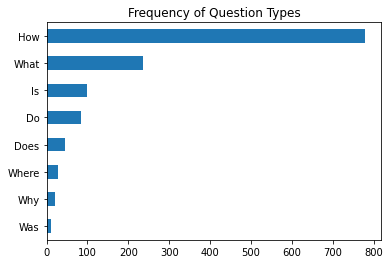

In [11]:
# let’s get a feel for what types of questions are in the training set by counting the questions that begin with a few common starting words
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
  counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [12]:
# let’s have a look at some examples
for question_type in ["How", "What", "Is"]:
  for question in (dfs["train"][dfs["train"].question.str.startswith(question_type)].sample(n=3, random_state=42)["question"]):
    print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


##Extracting Answers from Text